## House Prices: Advanced Linear Regression With NLME In R 

The data I used in this analysis is from [kaggle](https://www.kaggle.com/shivachandel/kc-house-data) and contains 21 features on over 20,000 houses at the time of their sale. The data itself is very clean and doesn't contain any missing values which makes it unrealistic but nice for practice and exploring new techniques.


* [Getting Set Up And Exploring The Date](#data)
* [Using Classical Linear Models](#lm)
* [Exploring Heteroscedasticiy With gls()](#gls1)
* [Using Linear Mixed Effects Model](#lmm)
* [Exploring Spatially Correlated Residual Errors With gls()](#gls2)
* [Conclusion](#fin)

<a id='data'></a>
### Getting Set Up and Exploring The Data

In [3]:
x <- c("lattice", "rje", "nlme", "ggplot2", "gridExtra")
lapply(x, require, character.only = TRUE)

Loading required package: lattice

Loading required package: rje

Loading required package: nlme

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked _by_ ‘.GlobalEnv’:

    mpg


Loading required package: gridExtra



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

In [5]:
library(readr)
kc_house_data <- read.csv("kc_house_data.csv")

Since there's no missing data we can get right into some x y plots to check out the data. 

[1] "id"            "date"          "price"         "bedrooms"     
 [5] "bathrooms"     "sqft_living"   "sqft_lot"      "floors"       
 [9] "waterfront"    "view"          "condition"     "grade"        
[13] "sqft_above"    "sqft_basement" "yr_built"      "yr_renovated" 
[17] "zipcode"       "lat"           "long"          "sqft_living15"
[21] "sqft_lot15"

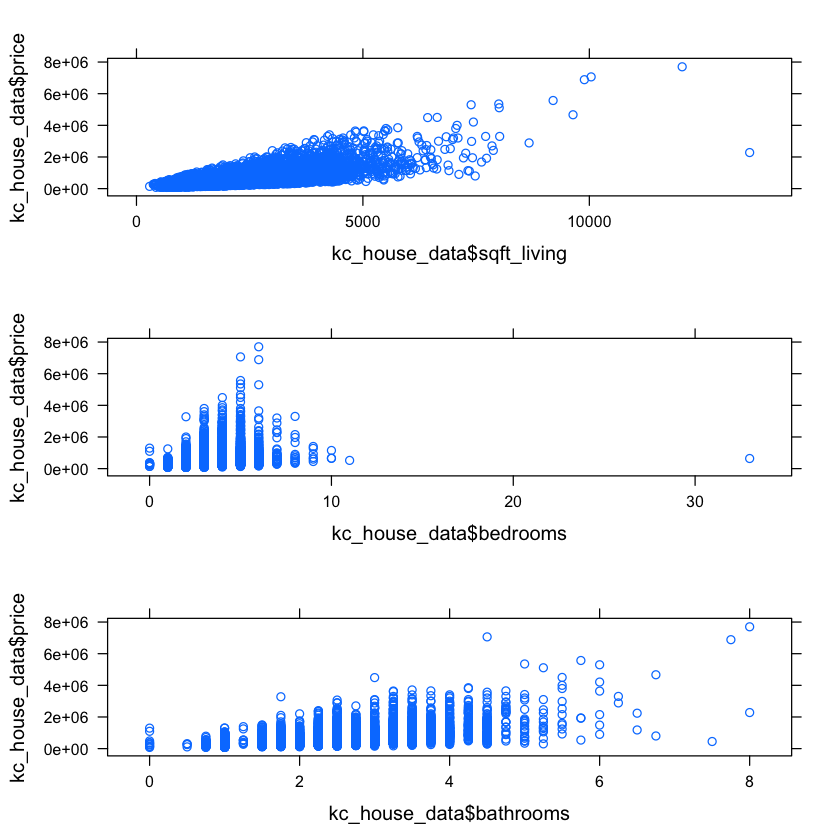

In [25]:
###these are just from a few of the covariates
names(kc_house_data)
grid.arrange(xyplot(kc_house_data$price ~ kc_house_data$sqft_living),
             xyplot(kc_house_data$price ~ kc_house_data$bedrooms),
            xyplot(kc_house_data$price ~ kc_house_data$bathrooms))



<a id='lm'></a> 
### Using Classical Linear Models

So it looks like price is linearly dependent on a lot of these covariates, and because of the nature of the data we also don't have to deal with any sensoring. We can get right into a classical linear model and see what we get. The first thing we are going to want to check out is if the residuals are normally distributed


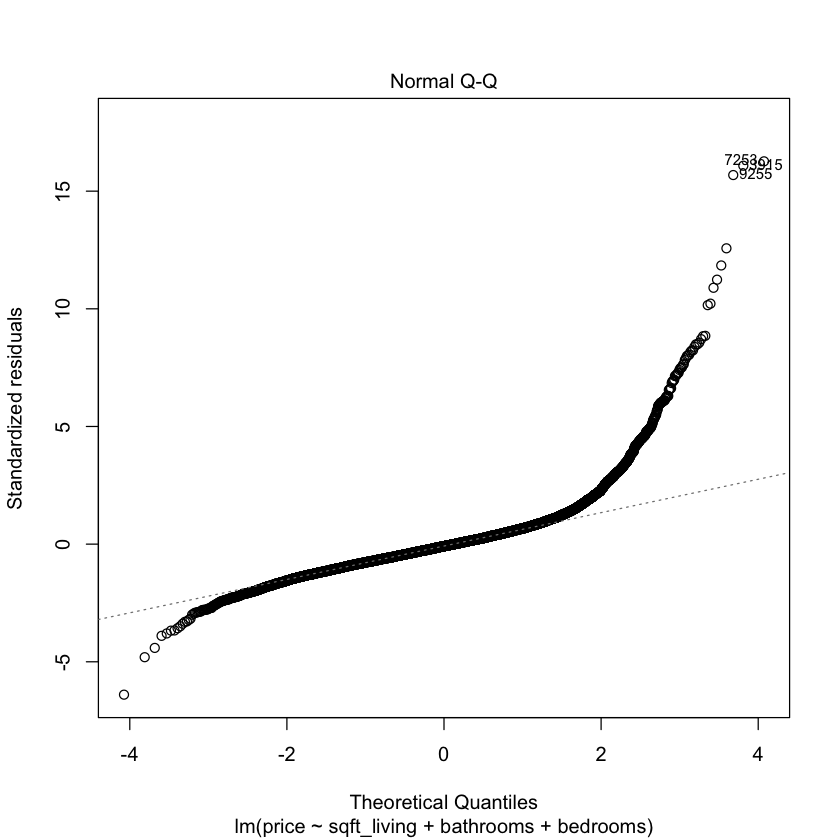

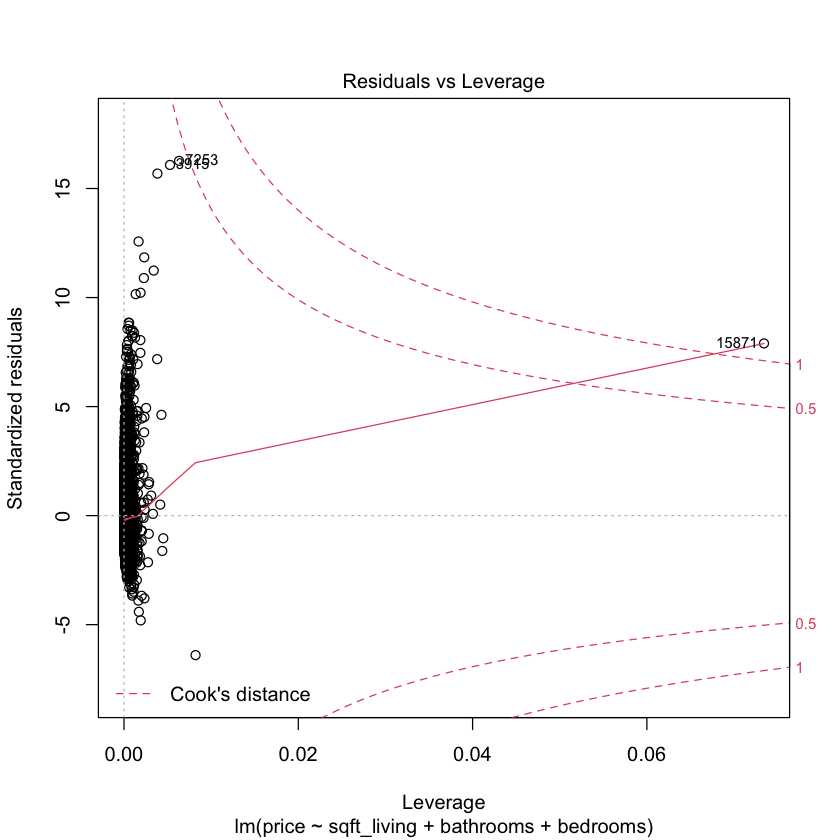

In [14]:

##just using a few covariates at the moment to demonstrate
fitlm <- fitlm <- lm(data = kc_house_data, formula = price ~ sqft_living + bathrooms + bedrooms)
plot(fitlm, 2)
plot(fitlm, 5)




We can see our residuals have heavy tails. In this case logging the response seems to do the trick. Additionally there were a handful of extreme outliers that came up throughout my analysis. I'm going to take them out now instead of as they come up just to keep things relatively concise. Below I print out some of the features of the worst outlier visible above.

,bedrooms,bathrooms
,<int>,<dbl>
15871,33,1.75


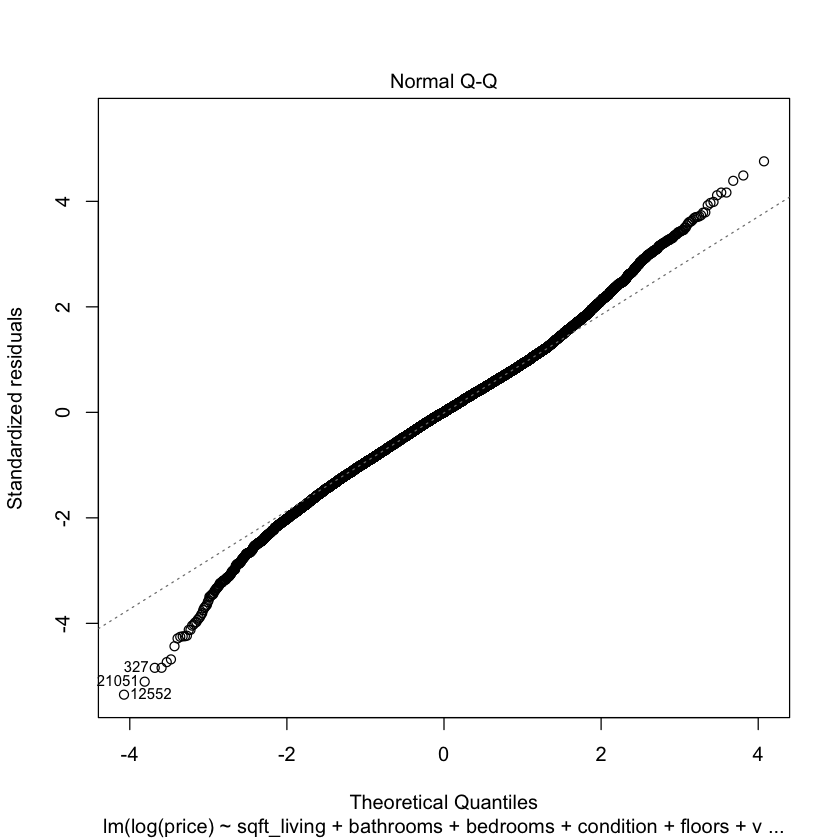


Call:
lm(formula = log(price) ~ sqft_living + bathrooms + bedrooms + 
    condition + floors + view + lat + long + grade + sqft_lot + 
    sqft_living15 + sqft_lot15 + yr_built + yr_renovated, data = house_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.36566 -0.16263  0.00098  0.15743  1.21284 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -5.445e+01  1.958e+00 -27.801  < 2e-16 ***
sqft_living    1.453e-04  4.269e-06  34.037  < 2e-16 ***
bathrooms      7.169e-02  4.083e-03  17.559  < 2e-16 ***
bedrooms      -1.465e-02  2.495e-03  -5.873 4.35e-09 ***
condition      6.852e-02  2.954e-03  23.192  < 2e-16 ***
floors         6.531e-02  4.071e-03  16.041  < 2e-16 ***
view           7.478e-02  2.473e-03  30.238  < 2e-16 ***
lat            1.354e+00  1.318e-02 102.709  < 2e-16 ***
long          -5.958e-02  1.480e-02  -4.026 5.70e-05 ***
grade          1.573e-01  2.705e-03  58.170  < 2e-16 ***
sqft_lot       4.450e-07  6.114e-08   7.2

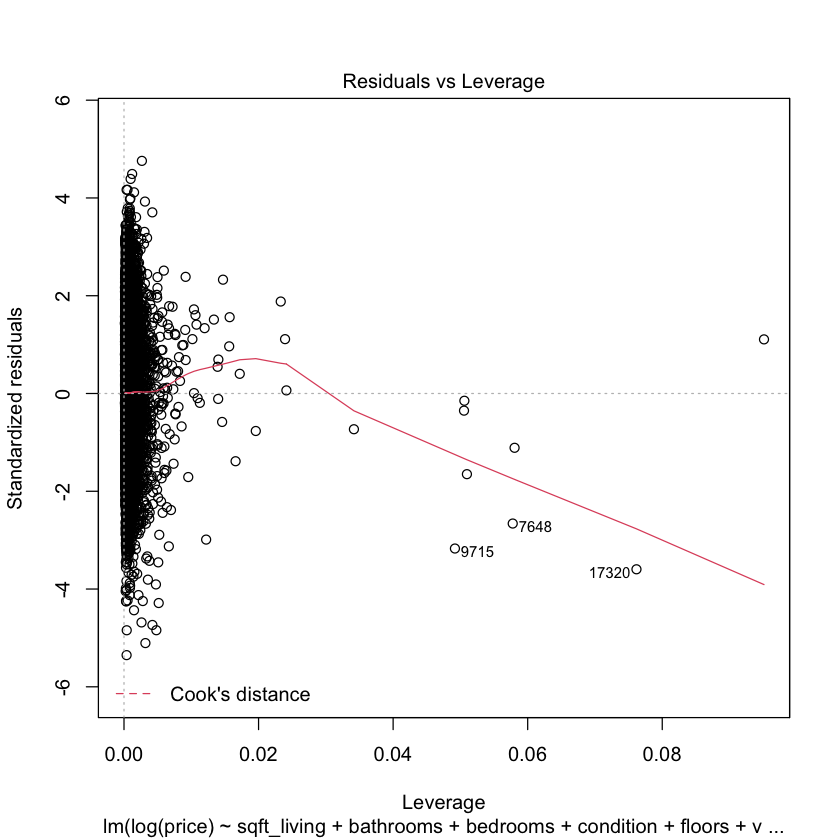

In [16]:
kc_house_data[15871,c("bedrooms", "bathrooms")]
house_data <- kc_house_data[-c(12778, 15871, 2965, 8451),]
## we can go ahead and throw in all the usable covariates
fitlm2 <- lm(data = house_data, formula = log(price) ~  sqft_living + bathrooms + bedrooms
             + condition + floors + view + lat + long + grade + sqft_lot + sqft_living15
              + sqft_lot15 + yr_built + yr_renovated)
# and check out the Q-Q after logging the response
plot(fitlm2, 2)
plot(fitlm2, 5)
summary(fitlm2)

The Q-Q plot doesn't look great but it's reasonbly straight and right out of the gate our model has an R squared > 0.75. All of our betas are significant and the model has a low p-value so that's about all we can ask of a classical linear model. 

The residual vs. leverage graph doesn't look great either but it's maybe not as bad as it seems given that there are over 20K observations.

We can proceed from this point because the dataset includes some interesting grouping factors that we did not include in our model. In paticular we have an indicator "waterfont", and a grouping factor "zipcode."

<a id='gls1'></a>
### Exploring Heteroscedasticity With `gls()`

Before we explore multilevel models with the `lme()` function it's a good idea to fit a couple `gls()` models with weights agrument of the form `varIdent(form = ~1|grouping_factor)`. This will fit a model with different residual variances in differnt groups. It requires far fewer parameters to be estimated than the models to come--and it'll give some indication of the importance of the grouping factor without having to compare a large number of no-pooling models.


Generalized least squares fit by REML
  Model: log(price) ~ sqft_above + sqft_living + bathrooms + bedrooms +      condition + floors + view + lat + long 
  Data: house_data 
       AIC      BIC    logLik
  7659.458 7755.225 -3817.729

Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | waterfront 
 Parameter estimates:
       0        1 
1.000000 1.554113 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) -84.66782 1.9134046 -44.24983       0
sqft_above    0.00008 0.0000061  12.73858       0
sqft_living   0.00028 0.0000060  47.21644       0
bathrooms     0.05988 0.0043295  13.83007       0
bedrooms     -0.03390 0.0027625 -12.27322       0
condition     0.08614 0.0031612  27.24777       0
floors        0.04727 0.0049209   9.60569       0
view          0.10335 0.0028735  35.96829       0
lat           1.56774 0.0144262 108.67311       0
long         -0.18023 0.0153338 -11.75394       0

 Correlation: 
            (Intr) sqft

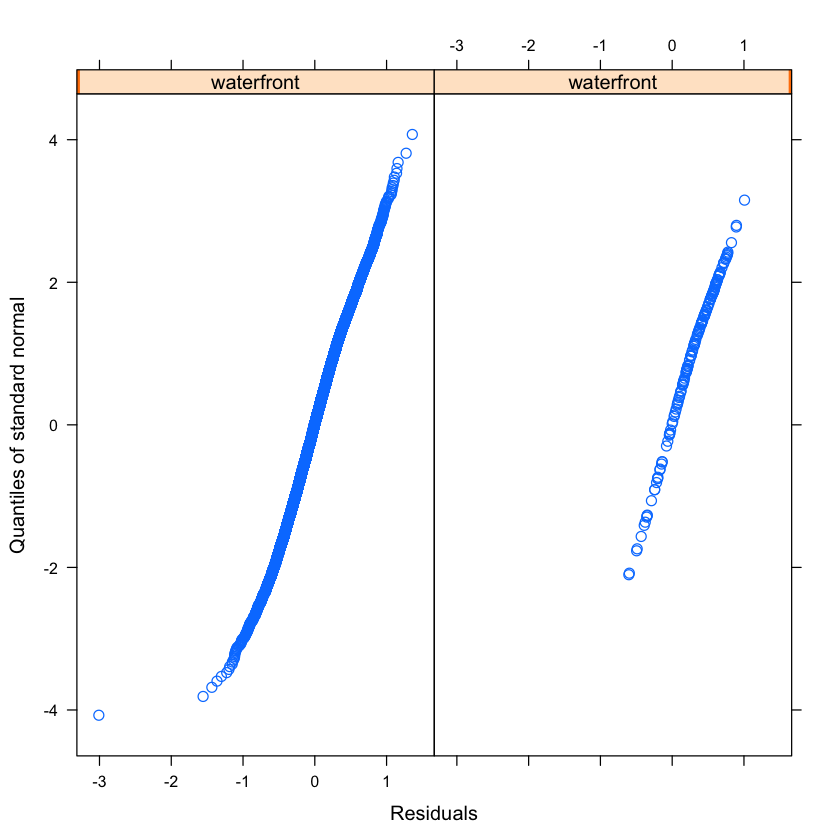

In [7]:
# simple example allowing different variances for houses on and not on waterfront
fitgls <- gls(data = house_data, model = log(price) ~  sqft_above + sqft_living + bathrooms 
              + bedrooms + condition + floors + view + lat + long, 
              weights = varIdent(form = ~1|waterfront))
summary(fitgls)
# plot normal Q-Q graph for each strata

qqnorm(fitgls, form = (~resid(.)|waterfront))

We can see in the summary that the two "variance parameter" estimates are quite different (1, 1.55). It's worth noting that these aren't the actual estimated variances as another parameter sigma squared is also estimated separately. And while we can see that our residual standard error didn't get smaller, we should model each strata separately to see what's going on. 

In [18]:
## it turns out that many of the covariates lose statistical significance when waterfront=1

fitlm3 <- lm(data = house_data, formula = log(price) ~ sqft_living  + condition  
             + sqft_living15  + grade + lat + long, subset = (waterfront == 1) )

# I just want to show the difference in R squared between the two 
summary(update(fitlm2, subset = (waterfront == 0)))$r.squared
summary(fitlm3)$r.squared

[1] 0.7602081

[1] 0.8681779

At this point we might be tempted to use a multilevel model to add random effects based on the waterfront indicator but that approach would be inappropriate. The issue is that there are only two levels to the waterfront factor. As a rule of thumb you shouldn't use a factor with fewer than ten levels in a random effect for a mixed model. In this case since there are 163 observations with waterfront = 1 it's probably best to just use separate models.

From here on I will only analyse the subset with waterfront = 0 as its R squared didn't get much better and this subset has the vast majority of the observations.

At this point I want to talk a little about the lat and long covariates. For whatever reason in this dataset price appears to be monotonly dependent on both lat and long. In the context of more advanced models there is also some redundancy between these covariates and the zipcode factor. This isn't an issue but I want to play around with some ideas which would be more impactful if we had only either lat,long or zipcode.

Also R doesn't love fitting these more advanced models on datasets with 20K obs. and grouping factors with 70 models so let's take some samples to play around with these ideas.

In [20]:
h_samp <- house_data[which(house_data$waterfront == 0),]
z_samp <- sample(levels(factor(h_samp$zipcode)), 10)
h_samp <- house_data[which(house_data$zipcode %in% z_samp),]
h_samp <- h_samp[sample(nrow(h_samp), 600),]
fitgls <- gls(data = h_samp, model = log(price) ~  sqft_above + sqft_living + bathrooms + bedrooms
      + condition + floors + view + lat + long,  weights = varIdent(form = ~1|zipcode))
## display the residual standard error or our new model and the classical lm on the new data 
sigma(fitgls)
sigma(update(fitlm2, data = h_samp))

[1] 0.1866981

[1] 0.2625075

If we run the above cell a few time to get new sample we can see quite a lot of variation in the gls model's rse, but it's often lower than the classical linear model's.

In general, weights arguments are much more than a diagnostic tool and should be explored any time you suspect the homoscedasticity assumption of classical linear models isn't being met. Often this shows up as "cones" in your scatter plots.

<a id='lmm'></a>
### Using a Linear Mixed Effects Model


Let's go ahead and fit a simple mixed model and see if we can capitalize on the hierarchical structure we're seeing.

[1] 0.1823766

[1] 0.2532668

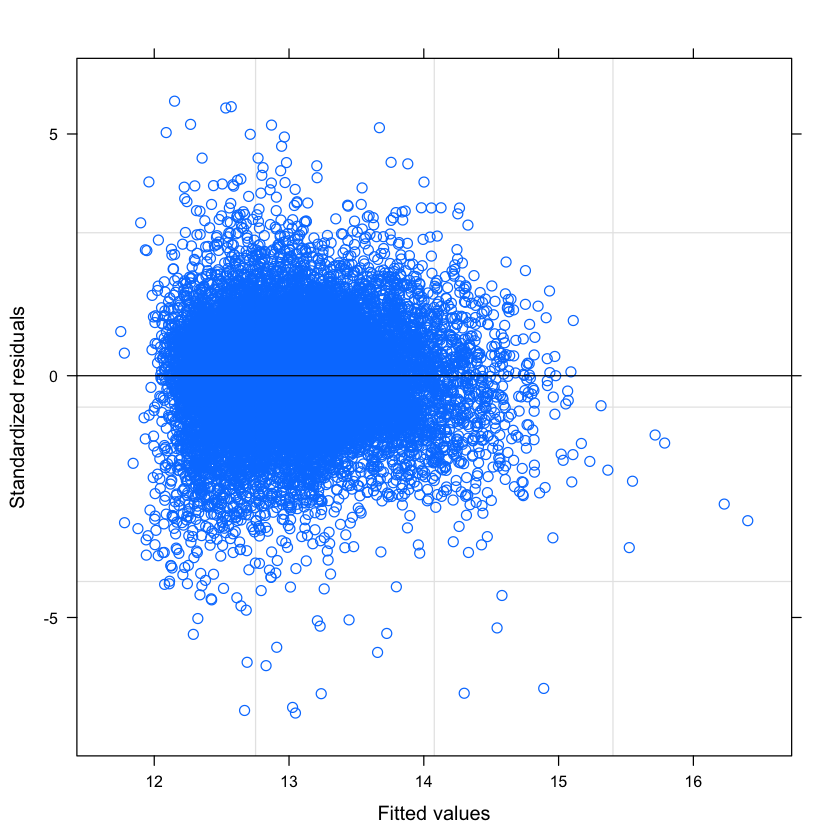

In [22]:
no_water <- house_data[which(house_data$waterfront == 0),]

fitlme <- lme(data = no_water, fixed = log(price) ~  sqft_above + sqft_living + bathrooms
                        + condition + floors + view + lat + long + grade
                        + sqft_living15 + sqft_lot15 + yr_built + yr_renovated,
                             random = ~view|zipcode)
##compare rse with new model and classcial lm on the obs with waterfront == 0


sigma(fitlme)
sigma(update(fitlm2, data = no_water))

## I didn't print the residual vs fitted of the origin lm so I'll just share this one
plot(fitlme)


So it looks like including a random effect improved our model quite a bit. This isn't _the_ simplest mixed effects model we could have made, but it's only one notch above that (we could have passed a reStruct class object of the form `~1|zipcode`). And to get more techincal we could have specified the covariance structure of the random effect with the more general syntax `random = list(zipcode = pdDiag(~condition)`), where `pdDiag` can be substituted for any `pdMat` object. Additionally, we could have included more covariates into our random effect, for example including bedrooms as in `random = ~view + bedrooms|zipcode` further reduces the rse to around .1812. In this case however, I think the model typed above is acceptable.

It shouldn't be overlooked that we also could have included a weights argument as we did before, as well as a correlation argument to specify the covariance structure of the conditional response distribution (more on this next). 

In this case R will have a heart attach if you try to include a weights argument.

We can inspect the predictions associated with the random effect by using `ranef(fitlme)`. I omitted this for brevity.

<a id='gls2'></a>
### Exploring Spatially Correlated Residual Errors With `gls()`
Finally I just want to share a quick demo of correlation structures on this same dataset. We can pretent that we don't have a zipcode factor and the relationship between price and each of lat and long isn't monotone. In such a scenario we might want to allow for covariance between observations that were geographically near one another. That is what the correlation argument in `gls()` and `lme()` allows us to do. There are a variety of objects in the `corStruct` class which allow for spatial correlation: `corExp`, `corGaus`, `corLin` are a few options. 

Unfortunately in the case of this dataset the lat,long features are not precise enough to differentiate all of the observations resulting in observations that are zero distance from one another. This same issue happens in longitudinal data, but in that case grouping observations by individual resolves the problem. In our demo case I simply add noise to the lat,long features to "jitter" them. 

I am also going to take a new, smaller sample from only a few zipcodes so I can demo how to print out one of the block matricies corresponding to one of the zipcodes.

In [28]:
##take a new small sample
h_samp2 <- house_data[which(house_data$waterfront == 0),]
z_samp2 <- sample(levels(factor(h_samp2$zipcode)), 6)
h_samp2 <- house_data[which(house_data$zipcode %in% z_samp2),]
h_samp2 <- h_samp2[sample(nrow(h_samp2), 200),]

##jitter the lat and long, might need to rerun this cell if it doesn't work first time
n1 <- round(rnorm(200)/100,4)
n2 <- round(rnorm(200)/100,4)

h_samp2$lat + n1
h_samp2$long + n2

##specify a gls with a corStruct of type corGaus

fitgls2 <- gls(data = h_samp2, model = log(price) ~  sqft_above + sqft_living + bathrooms 
              + bedrooms + condition + floors + view, 
     correlation = corGaus(form = (~lat + long|zipcode), metric = "euclidean", nugget = .01))
##print out one of the covariance matricies
getVarCov(fitgls2, individual  = 1)

[1] 47.7214 47.6973 47.6412 47.6896 47.7155 47.3698 47.6946 47.7708 47.7155
 [10] 47.6809 47.7015 47.6807 47.7062 47.3282 47.6461 47.3475 47.3736 47.6367
 [19] 47.7143 47.3763 47.4349 47.4533 47.6804 47.6774 47.6630 47.4379 47.6848
 [28] 47.6952 47.6778 47.6663 47.3508 47.6640 47.4351 47.7256 47.6798 47.7637
 [37] 47.6669 47.6585 47.3602 47.3857 47.7060 47.7055 47.6623 47.6885 47.3972
 [46] 47.7122 47.4727 47.7135 47.6412 47.7681 47.7482 47.6748 47.6749 47.6726
 [55] 47.6906 47.6405 47.6896 47.6879 47.6606 47.6519 47.6464 47.7360 47.6835
 [64] 47.3722 47.4334 47.6725 47.6744 47.7215 47.3519 47.6942 47.7224 47.7045
 [73] 47.6854 47.7118 47.7292 47.6300 47.7528 47.7395 47.6355 47.6828 47.6729
 [82] 47.7526 47.7027 47.6470 47.6974 47.4545 47.6779 47.6308 47.3784 47.4333
 [91] 47.6611 47.6532 47.6990 47.7274 47.7150 47.7335 47.6507 47.7454 47.6813
[100] 47.4557 47.7423 47.3468 47.6902 47.6819 47.7034 47.6997 47.6597 47.6351
[109] 47.7021 47.7184 47.6711 47.6639 47.7410 47.7248 47.6991 47.7767 47.6848
[118] 47.3679 47.7381 47.6471 47.6871 47.3590 47.7480 47.6945 47.6632 47.6980
[127] 47.6973 47.6441 47.6710 47.3711 47.6744 47.6835 47.6589 47.6919 47.6645
[136] 47.7134 47.7298 47.6451 47.6321 47.6948 47.6841 47.7410 47.4673 47.6728
[145] 47.6588 47.6946 47.6920 47.6318 47.6587 47.6793 47.6818 47.6945 47.6705
[154] 47.7234 47.7372 47.6752 47.3562 47.6867 47.6893 47.6946 47.7024 47.6625
[163] 47.6854 47.3694 47.6588 47.6997 47.6150 47.7332 47.4065 47.4467 47.7228
[172] 47.6497 47.4469 47.6910 47.6822 47.6589 47.6567 47.6585 47.7004 47.4307
[181] 47.4650 47.7607 47.3460 47.6905 47.3741 47.3956 47.4683 47.6588 47.6561
[190] 47.4645 47.7725 47.4418 47.6901 47.6993 47.6354 47.4526 47.7059 47.6662
[199] 47.7069 47.6660

[1] -122.0212 -122.3385 -122.3452 -122.3322 -122.3432 -122.2130 -122.3512
  [8] -122.3338 -122.3371 -122.3477 -122.3438 -122.0174 -122.0290 -122.1796
 [15] -122.3187 -122.1831 -122.1999 -121.9479 -122.3211 -122.2021 -122.2874
 [22] -122.2623 -122.3364 -122.0063 -122.3371 -122.2769 -122.0326 -122.3453
 [29] -122.3405 -122.3684 -122.2007 -122.0208 -122.3265 -122.3334 -122.3584
 [36] -122.3322 -122.0677 -122.3549 -122.2035 -122.2177 -122.3541 -122.3493
 [43] -122.3358 -122.3359 -122.1690 -122.3530 -122.2812 -122.0159 -122.3287
 [50] -122.3356 -122.3314 -122.3548 -122.3366 -122.0503 -122.0312 -122.3494
 [57] -122.3511 -122.3691 -122.3514 -122.3199 -122.3191 -122.3503 -122.3607
 [64] -122.1637 -122.3172 -122.3336 -122.0522 -122.3382 -122.1973 -122.3426
 [71] -122.0015 -122.3274 -122.3602 -122.3543 -122.3657 -122.3582 -122.3448
 [78] -122.3400 -121.9967 -122.3309 -122.3349 -122.3620 -122.0323 -122.0468
 [85] -122.3436 -122.2697 -122.0747 -121.9701 -122.2027 -122.2857 -122.0297
 [92] -122.0038 -122.3376 -122.3388 -122.0230 -122.3421 -122.3454 -122.3370
 [99] -122.3481 -122.2882 -122.3410 -122.1887 -122.3567 -122.3586 -122.0417
[106] -122.3446 -122.3443 -122.3649 -122.0233 -122.3351 -122.0413 -122.3275
[113] -122.3483 -122.3462 -122.3328 -122.3381 -122.3433 -122.2222 -122.3278
[120] -122.3446 -122.3530 -122.2009 -122.3508 -122.3504 -122.3712 -122.3406
[127] -122.3428 -122.3536 -122.3127 -122.1855 -122.3619 -122.0180 -122.3319
[134] -122.3287 -122.3519 -122.3521 -122.3588 -121.9565 -121.9430 -122.3480
[141] -122.3433 -122.3373 -122.2954 -122.3297 -122.0410 -122.3333 -122.0411
[148] -121.9520 -122.3483 -122.3533 -122.3423 -122.3447 -122.3526 -122.3208
[155] -122.3104 -121.9992 -122.1683 -122.3461 -122.0200 -122.3491 -122.3675
[162] -122.3422 -122.3420 -122.1929 -122.0344 -122.3334 -121.9807 -122.3366
[169] -122.2324 -122.2916 -122.3363 -122.3646 -122.2706 -122.3400 -122.3371
[176] -122.3613 -122.0151 -122.3533 -122.3359 -122.2958 -122.3334 -122.3224
[183] -122.1851 -121.9998 -122.1642 -122.2303 -122.3265 -122.0503 -122.3437
[190] -122.2737 -122.3392 -122.2841 -122.0364 -122.3445 -122.3502 -122.3245
[197] -122.3408 -122.3448 -122.3665 -122.3463

Marginal variance covariance matrix
             [,1]        [,2]        [,3]        [,4]        [,5]        [,6]
 [1,]  1.0654e-01  0.0000e+00 1.8687e-235 7.8698e-189  1.7548e-40 2.0532e-191
 [2,]  0.0000e+00  1.0654e-01  2.6956e-88  5.7620e-92  0.0000e+00  8.1553e-95
 [3,] 1.8687e-235  2.6956e-88  1.0654e-01  9.0943e-24 8.6601e-100  5.3162e-08
 [4,] 7.8698e-189  5.7620e-92  9.0943e-24  1.0654e-01  2.1079e-99  4.9137e-07
 [5,]  1.7548e-40  0.0000e+00 8.6601e-100  2.1079e-99  1.0654e-01  5.3518e-84
 [6,] 2.0532e-191  8.1553e-95  5.3162e-08  4.9137e-07  5.3518e-84  1.0654e-01
 [7,] 1.8657e-146 7.8867e-126  2.2131e-29  2.0472e-04  2.0237e-72  2.1740e-09
 [8,]  9.0996e-41  0.0000e+00 9.6401e-115 6.7465e-120  8.4604e-03 6.5963e-101
 [9,]  0.0000e+00 2.5730e-264 1.0289e-106 1.0986e-223 7.2745e-220 1.1163e-160
[10,]  0.0000e+00  5.2647e-22  4.7461e-74 4.1816e-119  0.0000e+00 3.8494e-101
[11,]  0.0000e+00  7.6117e-80  2.8158e-31  1.3388e-95 1.1933e-209  6.2404e-63
[12,] 7.8913e-143 3.0531e-13

There are a few things to point out about what I did above. Firstly lat, long and euclidean in the same line should be a bit of a red flag but there isn't any way to handle geospatial distances appropriately with the prebuild `corStruct` objects. I suppose you could build a custom `corStruct` object using something like the `distm()` function from the geospatial package, but it's not going to make a difference unless your points are from all around the globe. Amd lastly the `nugget` is to introduce a discontinuity in the correlation function. Basically this prevents close observations from having correlation arbitrarily close to 1.

<a id='fin'></a>
### Conclusion

In this project I used a variety of different linear regression models to explain house sale price. In the end I ended up with two models for two different subsets of based on whether or not the house was located on waterfront. The model for the houses on the waterfront was a classical linear model with a log transformed response which had a p-value < 2.2x10^-16 and an R squared > 0.86. The second model was a mixed effects model based on a classical linear model which also had a p-value < 2.2x10^-16, and an R squared > 0.76. The inclusion of a random effect reduced the residual standard error from 0.2533 in the classical model to 0.1824 in the mixed effect model.

It is worth noting that I only deleted four observations from the original dataset. Further investigation of high residual and leverage observations could have marginally improved these models.

Lastly, I toyed around with the idea of using the latitude and longitude features from the dataset to specify a spatial correlation structure for the (conditional) error covariance matrix. This was not included in either of the two models above and was simply for fun.

Below are the printed summaries of the two models referenced above.



In [24]:
summary(fitlm3) ### this is the model for houses on the waterfront
summary(fitlme)### this is the model for houses not on the waterfront
sigma(fitlme) ### rse




Call:
lm(formula = log(price) ~ sqft_living + condition + sqft_living15 + 
    grade + lat + long, data = house_data, subset = (waterfront == 
    1))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.83914 -0.14562  0.03305  0.18715  0.47307 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.835e+01  3.112e+01   0.911 0.363695    
sqft_living   1.599e-04  2.045e-05   7.821 7.75e-13 ***
condition     6.901e-02  2.751e-02   2.508 0.013161 *  
sqft_living15 1.512e-04  3.756e-05   4.026 8.86e-05 ***
grade         8.268e-02  1.952e-02   4.235 3.92e-05 ***
lat           1.597e+00  2.149e-01   7.428 7.08e-12 ***
long          7.525e-01  2.101e-01   3.582 0.000457 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2534 on 154 degrees of freedom
Multiple R-squared:  0.8682,	Adjusted R-squared:  0.863 
F-statistic:   169 on 6 and 154 DF,  p-value: < 2.2e-16


Linear mixed-effects model fit by REML
 Data: no_water 
        AIC      BIC   logLik
  -11347.81 -11204.3 5691.904

Random effects:
 Formula: ~view | zipcode
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev     Corr  
(Intercept) 0.25698800 (Intr)
view        0.03790305 -0.218
Residual    0.18237660       

Fixed effects: log(price) ~ sqft_above + sqft_living + bathrooms + condition +      floors + view + lat + long + grade + sqft_living15 + sqft_lot15 +      yr_built + yr_renovated 
                  Value Std.Error    DF  t-value p-value
(Intercept)   -62.30531  6.836891 21365 -9.11311       0
sqft_above      0.00008  0.000004 21365 17.92970       0
sqft_living     0.00013  0.000004 21365 33.65772       0
bathrooms       0.03935  0.002950 21365 13.33578       0
condition       0.05694  0.002200 21365 25.87601       0
floors         -0.03341  0.003615 21365 -9.24046       0
view            0.05109  0.005338 21365  9.57226       0
lat             

[1] 0.1823766